In [1]:
import rasterio
import rasterio.plot 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# for aggegating raster values with shapefiles
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

# To get lon/lat coordinates
import xarray as xr
from rasterio.warp import transform

# To make predictions
import tensorflow as tf

from utils import ROOT_DIR

from IPython.display import display, Markdown

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%load_ext autoreload
%autoreload 2

%matplotlib inline

<br><br><br>
# Definitions

In [2]:
def get_lon_lat_coordinates(filepath=ROOT_DIR + "/data/features/POP.tif"):
    # Code comes from http://xarray.pydata.org/en/v0.10.0/auto_gallery/plot_rasterio.html
    
    # Read the data
    da = xr.open_rasterio(filepath)

    # Compute the lon/lat coordinates with rasterio.warp.transform
    ny, nx = len(da['y']), len(da['x'])
    x, y = np.meshgrid(da['x'], da['y'])

    # Rasterio works with 1D arrays
    lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                         x.flatten(), y.flatten())

    lon = np.asarray(lon).reshape((ny, nx))
    lat = np.asarray(lat).reshape((ny, nx))
    
    lon_1d_array = lon.reshape(-1)
    lat_1d_array = lat.reshape(-1)
    
    # arrays with with shapes (849, 1469) transormed to array with shape (849*1469,)
    return lon_1d_array, lat_1d_array

In [3]:
def read_raster_file(filepath):
        # read raster data band1 from the .tif file
        raster_open = rasterio.open(filepath)
        raster_data = raster_open.read(1)
        raster_data_1d_array = raster_data.reshape(-1)

        # raster data defines -3.4e+38 as the value, when data is missing
        raster_na_value = np.float32(raster_open.nodata)
        raster_open.close()
        
        return raster_data_1d_array, raster_na_value

In [4]:
def get_featureData():
    featureData = pd.DataFrame()
    # POPNS - non scaled population size values - is not used for predictions, but only for transforming incidence rate (IR) to total cases (TC)
    featureTifs = ["ACCESS", "PET", "POP", "URBAN", "WACCESS", "POPNS"]
    shape = (849, 1469)
    # Initiliase
    raster_na_value = None

    # get LONG and LAT
    lon_1d_array, lat_1d_array = get_lon_lat_coordinates(ROOT_DIR + "/data/features/{}.tif".format(featureTifs[0]))
    featureData["LONG"] = lon_1d_array
    featureData["LAT"] = lat_1d_array

    for feature in featureTifs:
        filepath = ROOT_DIR + "/data/features/{}.tif".format(feature)
        raster_data_1d_array, raster_na_value = read_raster_file(filepath)
        featureData[feature] = raster_data_1d_array
            
    return featureData, raster_na_value, shape

In [5]:
def get_predictions(cleanedFeatureData, modelPath):
    model = tf.keras.models.load_model(modelPath)
    
    # POPNS - non scaled population size values - is not used for predictions, but only for transforming incidence rate (IR) to total cases (TC)
    data = cleanedFeatureData.copy().drop(columns="POPNS")
    # Normalize data as by training
    data["LONG"] = data["LONG"] / 180
    data["LAT"] = data["LAT"] / 90
        
    # The model output negative zero (-0.0) and np.absolute to avoid this behavior
    predictions = np.absolute(model.predict(data.values))
    return predictions

In [6]:
def prepare_predictions(predictions):
    # make predictions always 1d array
    predictions = predictions.reshape(-1)
    # # set negative predicted values to zero, because values should not be < 0
    #predictions[predictions < 0] = 0
    return predictions

In [7]:
def reshape_to_raster(array1D, raster_shape):
    return array1D.reshape(raster_shape)

In [8]:
def get_raster_data(featureData, cleanedFeatureData, adj_log_predictions, raster_na_value, raster_shape): 
    labels = pd.DataFrame(index=cleanedFeatureData.index)
    labels["LIR"] = prepare_predictions(LIR_predictions.copy())
    # LIR is log(IR + 1)
    # Therefore IR backwards is (exp(LIR) - 1)
    labels["IR"] = np.exp(labels["LIR"]) - 1
    # Calculate total cases by inverting the formula of IR = (TC / POPNS) * 100,000
    # np.float32() is needed to make the results np.float32 type, as default it returns np.float64 which causes bugs in the code
    labels["TC"] = np.float32(np.multiply(labels["IR"].values, cleanedFeatureData["POPNS"].values) / 100000)
    
    # logarithmic total cases to make it easier to see patterns
    labels["LTC"] = np.log(labels["TC"].values + 1)
    
    print(labels
          .describe()
          .round(4)
          .to_latex(columns=["IR", "LIR", "TC", "LTC"],
                    caption="Summary statistics of the predicted values of the raster",
                    label="tab:summary-statistics-raster-map"))
    
    
    # Test label data types to avoid saving bugs
    assert labels["LIR"].dtype == np.float32, "'LIR' values should be of type numpy.float32"
    assert labels["IR"].dtype == np.float32, "'IR' values should be of type numpy.float32"
    assert labels["TC"].dtype == np.float32, "'TC' values should be of type numpy.float32"
    assert labels["LTC"].dtype == np.float32, "'LTC' values should be of type numpy.float32"
    
    # fill not assigned label rows with raster_na_value
    # So are all NA values from prior raster_data masked
    labels = labels.reindex(featureData.index, fill_value=raster_na_value)
    
    return {"LIR": reshape_to_raster(labels["LIR"].values, raster_shape), 
            "IR": reshape_to_raster(labels["IR"].values, raster_shape),
            "TC": reshape_to_raster(labels["TC"].values, raster_shape),
            "LTC": reshape_to_raster(labels["LTC"].values, raster_shape)}


In [9]:
def save_raster(raster_data=None, file_name=None):
    filepath = ROOT_DIR + "/data/features/{}.tif".format("ACCESS")
    # read raster data band1 from the .tif file

    IR_raster_opened = rasterio.open(filepath)
    IR_raster = rasterio.open(
         ROOT_DIR + "/data/predictions/{}.tif".format(file_name),
         'w',
         driver='GTiff',
         height=raster_data.shape[0],
         width=raster_data.shape[1],
         count=1,
         dtype=raster_data.dtype,
         crs=IR_raster_opened.crs,
         transform=IR_raster_opened.transform,
         nodata=raster_na_value
    )
    
    assert raster_data.shape == shape, "raster_data should have shape {} to save it properly as a .tif file".format(shape)
    
    IR_raster.write(raster_data, 1)
    IR_raster.close()

In [10]:
def plot_rasters(raster_array, title, file_path, save=False):
    display(Markdown('## <center>Raster of {}</center>'.format(title)))
    raster_array = raster_array.copy()
    raster_array[raster_array == raster_na_value] = np.nan
    plt.figure(figsize = (20, 10))
    im = plt.imshow(raster_array, cmap="hot")
    cb = plt.colorbar(im, pad=0.02)
    cb.ax.tick_params(labelsize=30)
    # Disable axis and their borders
    plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(file_path, dpi=200, bbox_inches='tight')

In [11]:
def plot_raster_feature(flattened_feature_data, name, save=False):
    data_to_plot = flattened_feature_data.copy().values.reshape(shape)
    plot_rasters(raster_array=data_to_plot,
                 title="the feature {}".format(name),
                 file_path=ROOT_DIR + "/data/features/colored/{}.jpg".format(name),
                 save=save)

In [12]:
def save_raster_aggregated_shapefile(file_name, raster_file_names, column):
    shapefile = gpd.read_file(ROOT_DIR + "/data/shapefiles/China.shp")
    
    for column_index, raster_file_name in enumerate(raster_file_names):
        column_name = column[column_index]["name"]
        column_type = column[column_index]["type"]
        # add IR column with empty values to shapefile DataFrame
        shapefile.insert(loc=column_index, column=column_name, value=np.nan)

        # extract the raster values within the polygon
        with rasterio.open(ROOT_DIR + "/data/predictions/{}.tif".format(raster_file_name)) as src:
            for index, shape in enumerate(shapefile["geometry"]):
                # transform to GeJSON format
                geoms = [mapping(shape)]
                out_image, out_transform = mask(src, geoms, crop=True)
                # change nodata values to nan
                out_image[out_image == np.float32(src.nodata)] = np.nan
                if column_type is "rate":
                    shapefile.loc[index, column_name] = np.nanmean(out_image)
                elif column_type is "frequency":
                    shapefile.loc[index, column_name] = np.nansum(out_image)

    # Save modified Shapefile
    shapefile.to_file(ROOT_DIR + "/data/predictions/shapefiles/{}.shp".format(file_name), driver='ESRI Shapefile')

In [13]:
def get_province_data(JHU_file_path, predictions_shapefile_path):
    JHU_data_mar = pd.read_csv(JHU_file_path)
    predictions_shapefile = gpd.read_file(predictions_shapefile_path)

    JHU_cases = np.array([JHU_data_mar.loc[JHU_data_mar["uniqu_d"] == val]["cases"].values for val in predictions_shapefile["uniqu_d"]]).reshape(-1)

    predictions_shapefile.insert(3, "JHU_cases", JHU_cases)
    predictions_shapefile.insert(4, "differences", predictions_shapefile["TC"] - predictions_shapefile["JHU_cases"])
    predictions_shapefile.insert(5, "diff_log10", np.log10(np.abs(predictions_shapefile["TC"] - predictions_shapefile["JHU_cases"])))
    predictions_shapefile.insert(6, "differences_p", predictions_shapefile["differences"] / predictions_shapefile["TC"] * 100)

    predicted_with_JHU = predictions_shapefile[["geometry", "uniqu_d", "admin", "TC", "JHU_cases", "differences", "diff_log10", "differences_p"]]
    predicted_with_JHU_without_hubei = predicted_with_JHU.loc[predicted_with_JHU["uniqu_d"] != "Hubei"]
        
    return predicted_with_JHU, predicted_with_JHU_without_hubei

In [14]:
def plot_shapefile_map(data, column_name, title, color="viridis", vmin=None, vmax=None, figsize=(20, 10), save=False):
    data = data.copy()
    display(Markdown('## <center>{}</center>'.format(title)))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    data.plot(column=column_name, ax=ax, legend=True, cmap=color, vmin=vmin, vmax=vmax, edgecolor="black", legend_kwds={"pad": 0.0})
    # Change colorbar labelsize
    fig.get_axes()[-1].tick_params(labelsize=30)
    # Set Background color
    #ax.patch.set_facecolor("black")
    # Disable axis and their borders
    ax.axis("off")
    # Disable ticks
    #plt.xticks([], [])
    #plt.yticks([], [])
    plt.tight_layout()
    
    # Annotate Map provinces
    data['coords'] = data['geometry'].apply(lambda x: x.representative_point().coords[:])
    data['coords'] = [coords[0] for coords in data['coords']]
    provinces_to_locate = [{"name":"Hong Kong", "offset":(2, -2), "arrow":True},
                           {"name":"Shanghai", "offset":(4, 0), "arrow": True},
                           {"name":"Beijing", "offset":(0,-0.15), "arrow": False},
                           {"name":"Tianjin", "offset":(2.5,-1.3), "arrow": True},
                           {"name":"Hebei", "offset":(0,-1), "arrow": False},
                           {"name":"Gansu", "offset":(1,-3), "arrow": False},
                           {"name":"Shaanxi", "offset":(-0.7,-2), "arrow": False},
                           {"name":"Inner Mongol", "offset":(-0.7,-1), "arrow": False},
                           {"name":"Hainan", "offset":(-0.5,-2), "arrow": True},
                           {"name":"Taiwan", "offset":(3,-1), "arrow": True},
                           {"name":"Chongqing", "offset":(-0.5,-0.8), "arrow": False},
                           {"name":"Guangdong", "offset":(2,0.5), "arrow": False},
                           {"name":"Jiangsu", "offset":(0.1,-1), "arrow": False},
                           {"name":"Ningxia", "offset":(0.1,-0.4), "arrow": False}]
    for idx, row in data.iterrows():
        (offset, arrow) = next(((item["offset"], item["arrow"]) for item in provinces_to_locate if item["name"] == row["uniqu_d"]), ((0,0), False))
        plt.annotate(text=idx+1, xy=row["coords"], 
                     xytext=(row['coords'][0] + offset[0], row['coords'][1] + offset[1]),
                     arrowprops=dict(arrowstyle="-", facecolor='green', alpha=0.6) if arrow else None,
                     fontsize=15,
                     horizontalalignment='center', 
                     c="white" if (row["differences"] > 500 or row["differences"] < -500) and not row["uniqu_d"] == "Hong Kong" else "black")

        plt.annotate(text="({}) {}".format(idx+1, row["uniqu_d"]),
             xy=(-100, 21*(32-idx)),
             xycoords="axes points",
             fontsize=15)
    
    if save:
        plt.savefig(ROOT_DIR + "/data/predictions/shapefiles/plots/{}.jpg".format(column_name), dpi=200, bbox_inches='tight')
        

In [15]:
def plot_JHU_vs_predictions_bar(data, title="predicted cases vs. JHU cases", ymin_1=None, ymax_1=None, ymin_2=None, ymax_2=None):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(30, 16))
    x = np.arange(len(data["uniqu_d"]))
    width = 0.35
    axs[0].bar(x - width/2, data["JHU_cases"], width=width, label="JHU cases",)
    axs[0].bar(x + width/2, data["TC"], width=width, label="predicted cases")
    axs[0].set_title(title, fontdict={"fontsize": 50}, pad=30)
    axs[0].legend(fontsize=20)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(data["uniqu_d"])
    axs[0].tick_params(axis="x", labelrotation=45, labelsize=20)
    axs[0].tick_params(axis="y", labelsize=20)
    axs[0].set_ylabel(ylabel="Number of cases", fontsize=30, labelpad=20)
    axs[0].set_ylim(ymin=ymin_1, ymax=ymax_1)

    # differences plot
    bar_color = np.where(data["differences"].values>0,'b','r').T
    axs[1].bar(data["uniqu_d"], data["differences"], color=bar_color, alpha=0.6)
    axs[1].tick_params(axis="x", labelrotation=45, labelsize=20)
    axs[1].tick_params(axis="y", labelsize=20)
    axs[1].set_ylabel(ylabel="predicted cases - JHU cases", fontsize=30, labelpad=20)
    axs[1].set_ylim(ymin=ymin_2, ymax=ymax_2)
    plt.tight_layout()

In [16]:
def metrics_predictions_vs_JHU(predicted_with_JHU):
    predicted_vs_JHU_without_hubei = predicted_with_JHU.copy().query("uniqu_d != 'Hubei'")
    
    metrics_predictions_vs_JHU = pd.DataFrame(index=["All  provinces", "Without Hubei"], columns=["RMSE", "MAE", "R2"])
    
    metrics_predictions_vs_JHU["RMSE"] = [np.sqrt(mean_squared_error(data["JHU_cases"], data["TC"])) for data in [predicted_with_JHU, predicted_vs_JHU_without_hubei]]
    metrics_predictions_vs_JHU["MAE"] = [mean_absolute_error(data["JHU_cases"], data["TC"]) for data in [predicted_with_JHU, predicted_vs_JHU_without_hubei]]
    metrics_predictions_vs_JHU["R2"] = [r2_score(data["JHU_cases"], data["TC"]) for data in [predicted_with_JHU, predicted_vs_JHU_without_hubei]]
    
    return metrics_predictions_vs_JHU

In [17]:
colored_raster_file_path_pattern = ROOT_DIR + "/data/predictions/colored/{}.jpg"
CONFIGS = {
    "hidden-layers-1": {
        "model_path": ROOT_DIR + "/best-models/mlp/hidden-layers-1",
        "raster_file_name": {
            "LIR": "LIR_h1",
            "IR": "IR_h1",
            "TC": "TC_h1",
            "LTC": "LTC_h1"
        },
        "colored_raster_file_path": {
            "LIR": colored_raster_file_path_pattern.format("LIR_h1"),
            "IR": colored_raster_file_path_pattern.format("IR_h1"),
            "TC": colored_raster_file_path_pattern.format("TC_h1"),
            "LTC": colored_raster_file_path_pattern.format("LTC_h1")
        },
        "shapefile": {
            "file_name": "cases_h1",
            "raster_file_names": ["IR_h1", "TC_h1"],
            "column": [{"name": "IR", "type": "rate"}, 
                       {"name": "TC", "type": "frequency"}] # column names must be less than 10 characters
        }
    },
    "hidden-layers-2": {
        "model_path": ROOT_DIR + "/best-models/mlp/hidden-layers-2",
        "raster_file_name": {
            "LIR": "LIR_h2",
            "IR": "IR_h2",
            "TC": "TC_h2",
            "LTC": "LTC_h2"
        },
        "colored_raster_file_path": {
            "LIR": colored_raster_file_path_pattern.format("LIR_h2"),
            "IR": colored_raster_file_path_pattern.format("IR_h2"),
            "TC": colored_raster_file_path_pattern.format("TC_h2"),
            "LTC": colored_raster_file_path_pattern.format("LTC_h2")
        },
        "shapefile": {
            "file_name": "cases_h2",
            "raster_file_names": ["IR_h2", "TC_h2"],
            "column": [{"name": "IR", "type": "rate"}, 
                       {"name": "TC", "type": "frequency"}] # column names must be less than 10 characters
        }
    }
}

<br><br><br>
# Generate Rasters and Shapefiles

In [18]:
# change value to generate raster and shape files for one or two hidden layer models
CURRENT_CONFIG = CONFIGS['hidden-layers-1']

In [19]:
featureData, raster_na_value, shape = get_featureData()
#featureData.to_csv(ROOT_DIR + "/data/features/features.csv", index=True, index_label="index", na_rep="NA")

In [20]:
cleanedFeatureData = featureData.replace(raster_na_value,np.nan).dropna()
#cleanedFeatureData.to_csv(ROOT_DIR + "/data/features/cleaned-features.csv", index=True, index_label="index", na_rep="NA")

In [21]:
# predictions takes longer, because there are about 0.5M Datapoints
LIR_predictions = get_predictions(cleanedFeatureData, CURRENT_CONFIG["model_path"])

In [22]:
# Number of Pixel/Predictions for the fine-scale map
numberOfPixels = len(LIR_predictions.reshape(-1))
print("Number of pixels/predictions for a fine-scale map: {:,}".format(numberOfPixels))

Number of pixels/predictions for a fine-scale map: 548,255


In [23]:
# Takes longer to predict 0.5M Datapoints
raster_data = get_raster_data(featureData, 
                              cleanedFeatureData, 
                              LIR_predictions,
                              raster_na_value,
                              shape)

\begin{table}
\centering
\caption{Summary statistics of the predicted values of the raster}
\label{tab:summary-statistics-raster-map}
\begin{tabular}{lrrrr}
\toprule
{} &           IR &          LIR &           TC &          LTC \\
\midrule
count &  548255.0000 &  548255.0000 &  548255.0000 &  548255.0000 \\
mean  &       0.8681 &       0.5447 &       0.0344 &       0.0276 \\
std   &       1.1210 &       0.3656 &       0.3966 &       0.0838 \\
min   &       0.0000 &       0.0000 &       0.0000 &       0.0000 \\
25\%   &       0.3447 &       0.2962 &       0.0001 &       0.0001 \\
50\%   &       0.9228 &       0.6538 &       0.0022 &       0.0022 \\
75\%   &       1.0538 &       0.7197 &       0.0226 &       0.0223 \\
max   &      37.7292 &       3.6566 &     116.2060 &       4.7639 \\
\bottomrule
\end{tabular}
\end{table}



In [24]:
for label_name in ["LIR", "IR", "LTC", "TC"]:
    # Save raster file for the label
    save_raster(raster_data=raster_data[label_name], 
                file_name=CURRENT_CONFIG["raster_file_name"][label_name])
    
# Aggregate raster values by China's shapefile and save new shapefile
save_raster_aggregated_shapefile(file_name=CURRENT_CONFIG['shapefile']["file_name"],
                                raster_file_names=CURRENT_CONFIG['shapefile']["raster_file_names"],
                                column=CURRENT_CONFIG['shapefile']["column"])

<br><br><br>
# Visualisations

## <center>Raster of LIR</center>

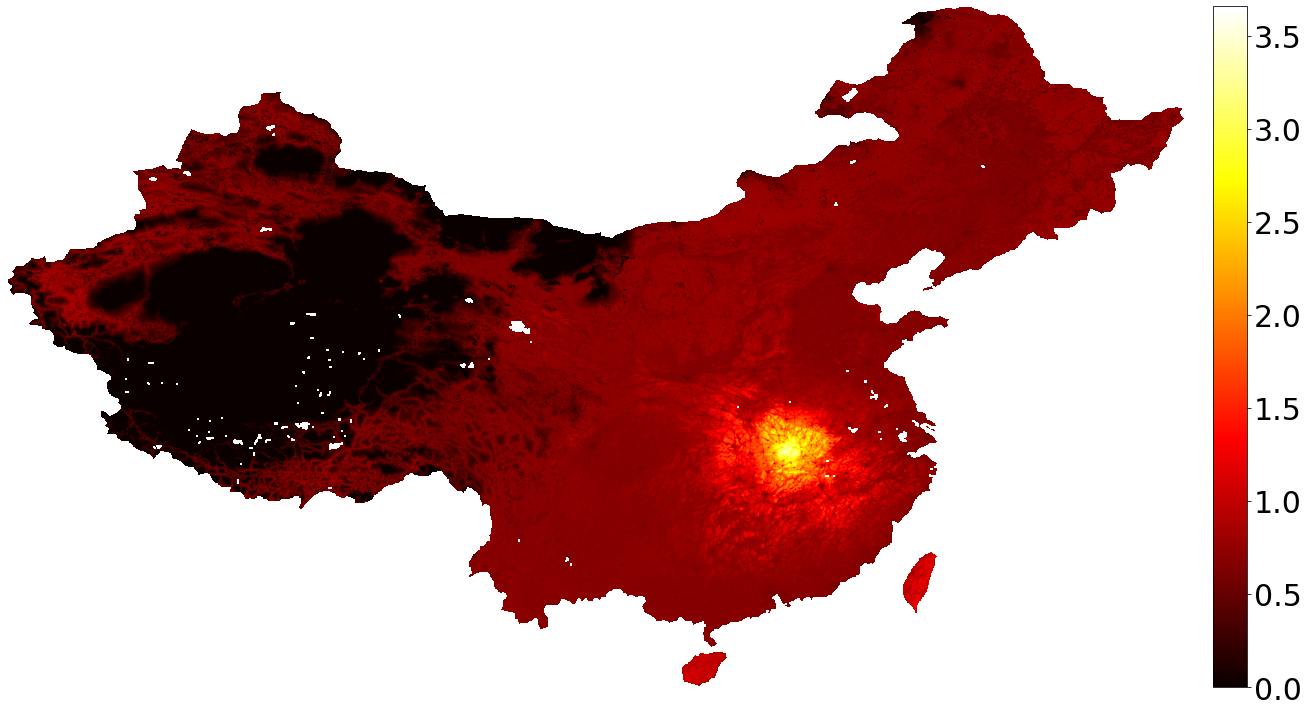

In [25]:
plot_rasters(raster_array=raster_data["LIR"],
             title="LIR",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["LIR"],
             save=True)

## <center>Raster of IR</center>

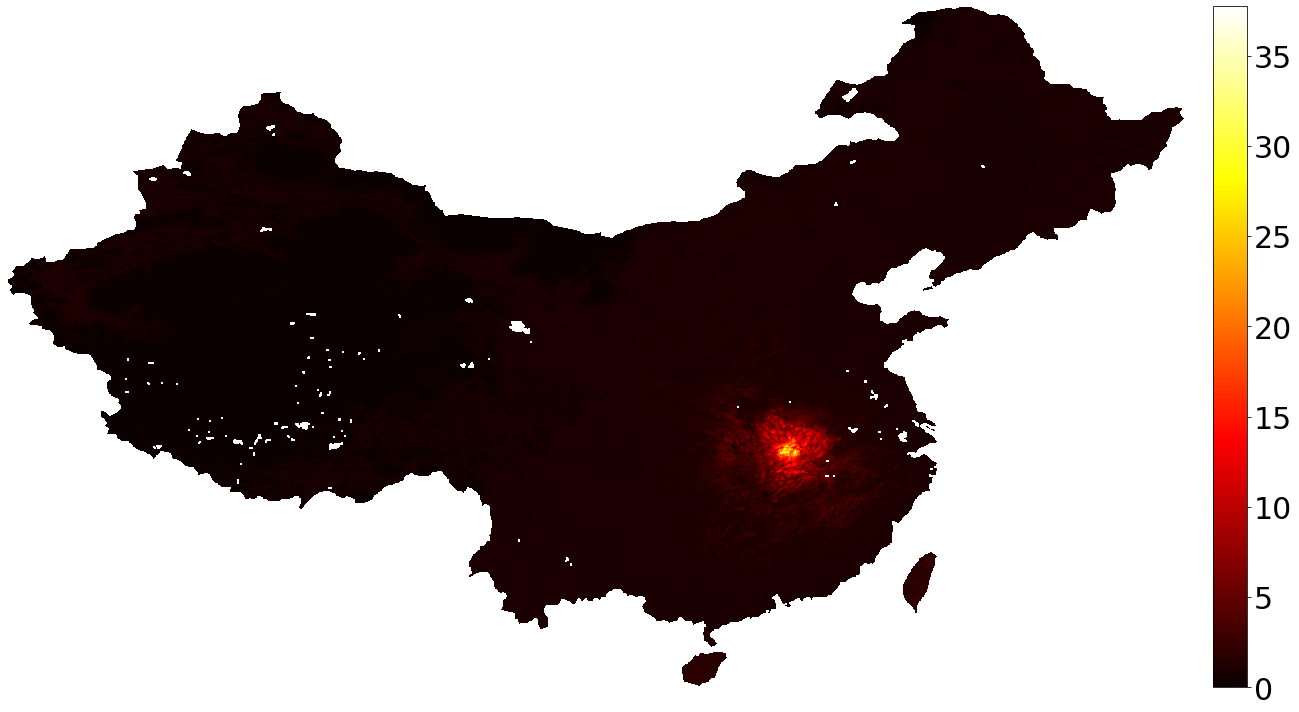

In [26]:
plot_rasters(raster_array=raster_data["IR"],
             title="IR",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["IR"],
             save=True)

## <center>Raster of LTC</center>

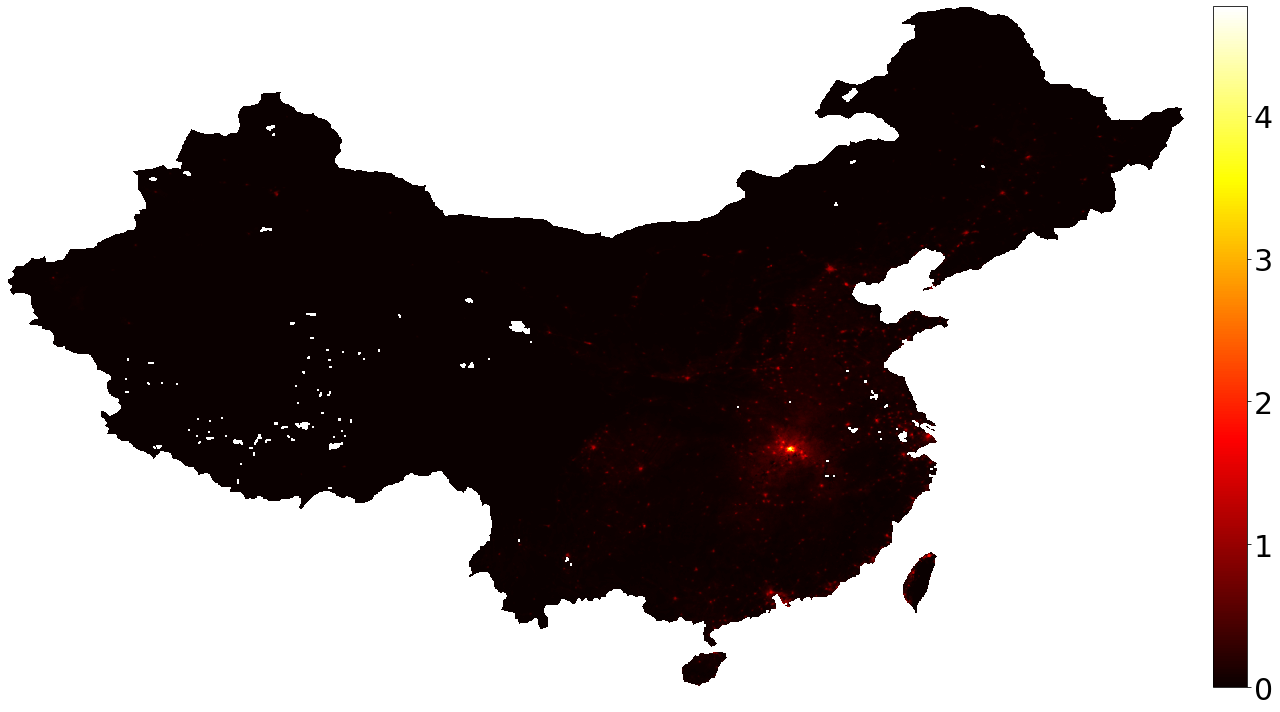

In [27]:
plot_rasters(raster_array=raster_data["LTC"],
             title="LTC",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["LTC"],
             save=True)

## <center>Raster of TC</center>

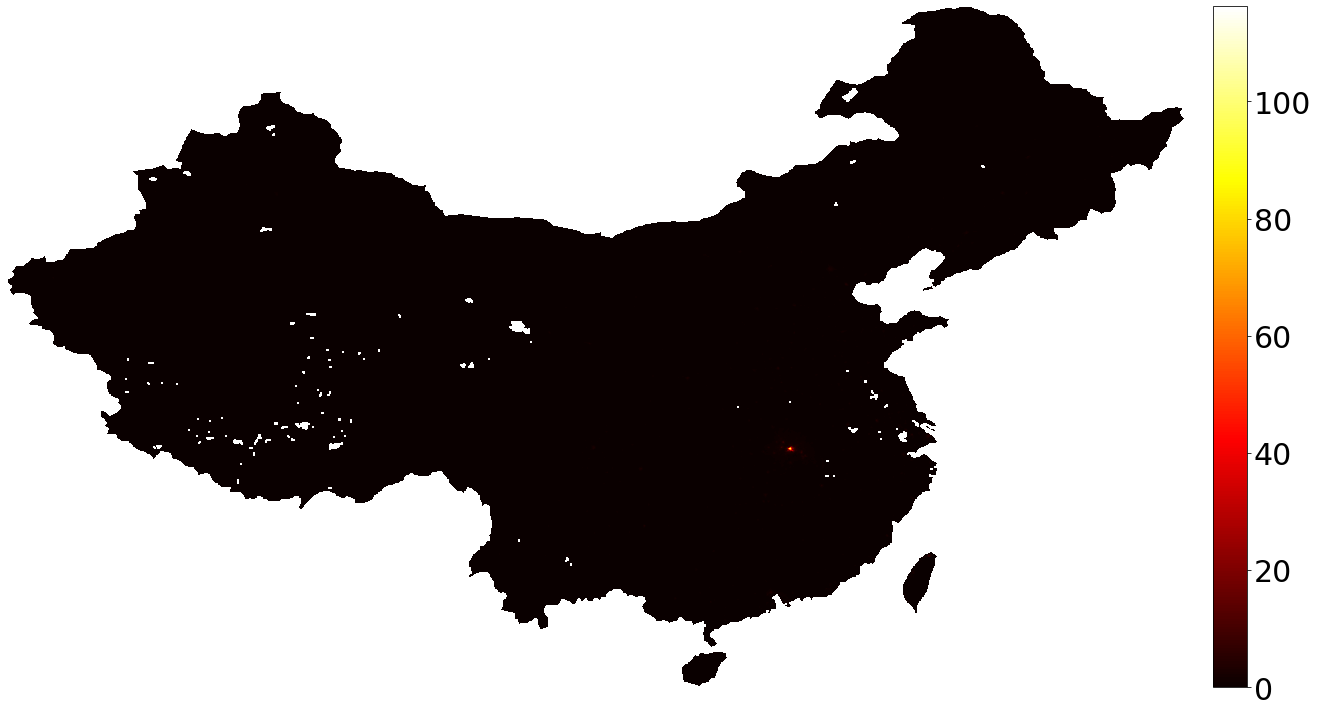

In [28]:
plot_rasters(raster_array=raster_data["TC"],
             title="TC",
             file_path=CURRENT_CONFIG["colored_raster_file_path"]["TC"],
             save=True)

In [29]:
predicted_with_JHU, predicted_with_JHU_without_hubei = get_province_data(JHU_file_path=ROOT_DIR + "/data/csvs/JHU/JHUJanMar.csv", 
                                                                         predictions_shapefile_path=ROOT_DIR + "/data/predictions/shapefiles/{}.shp".format(CURRENT_CONFIG['shapefile']['file_name']))


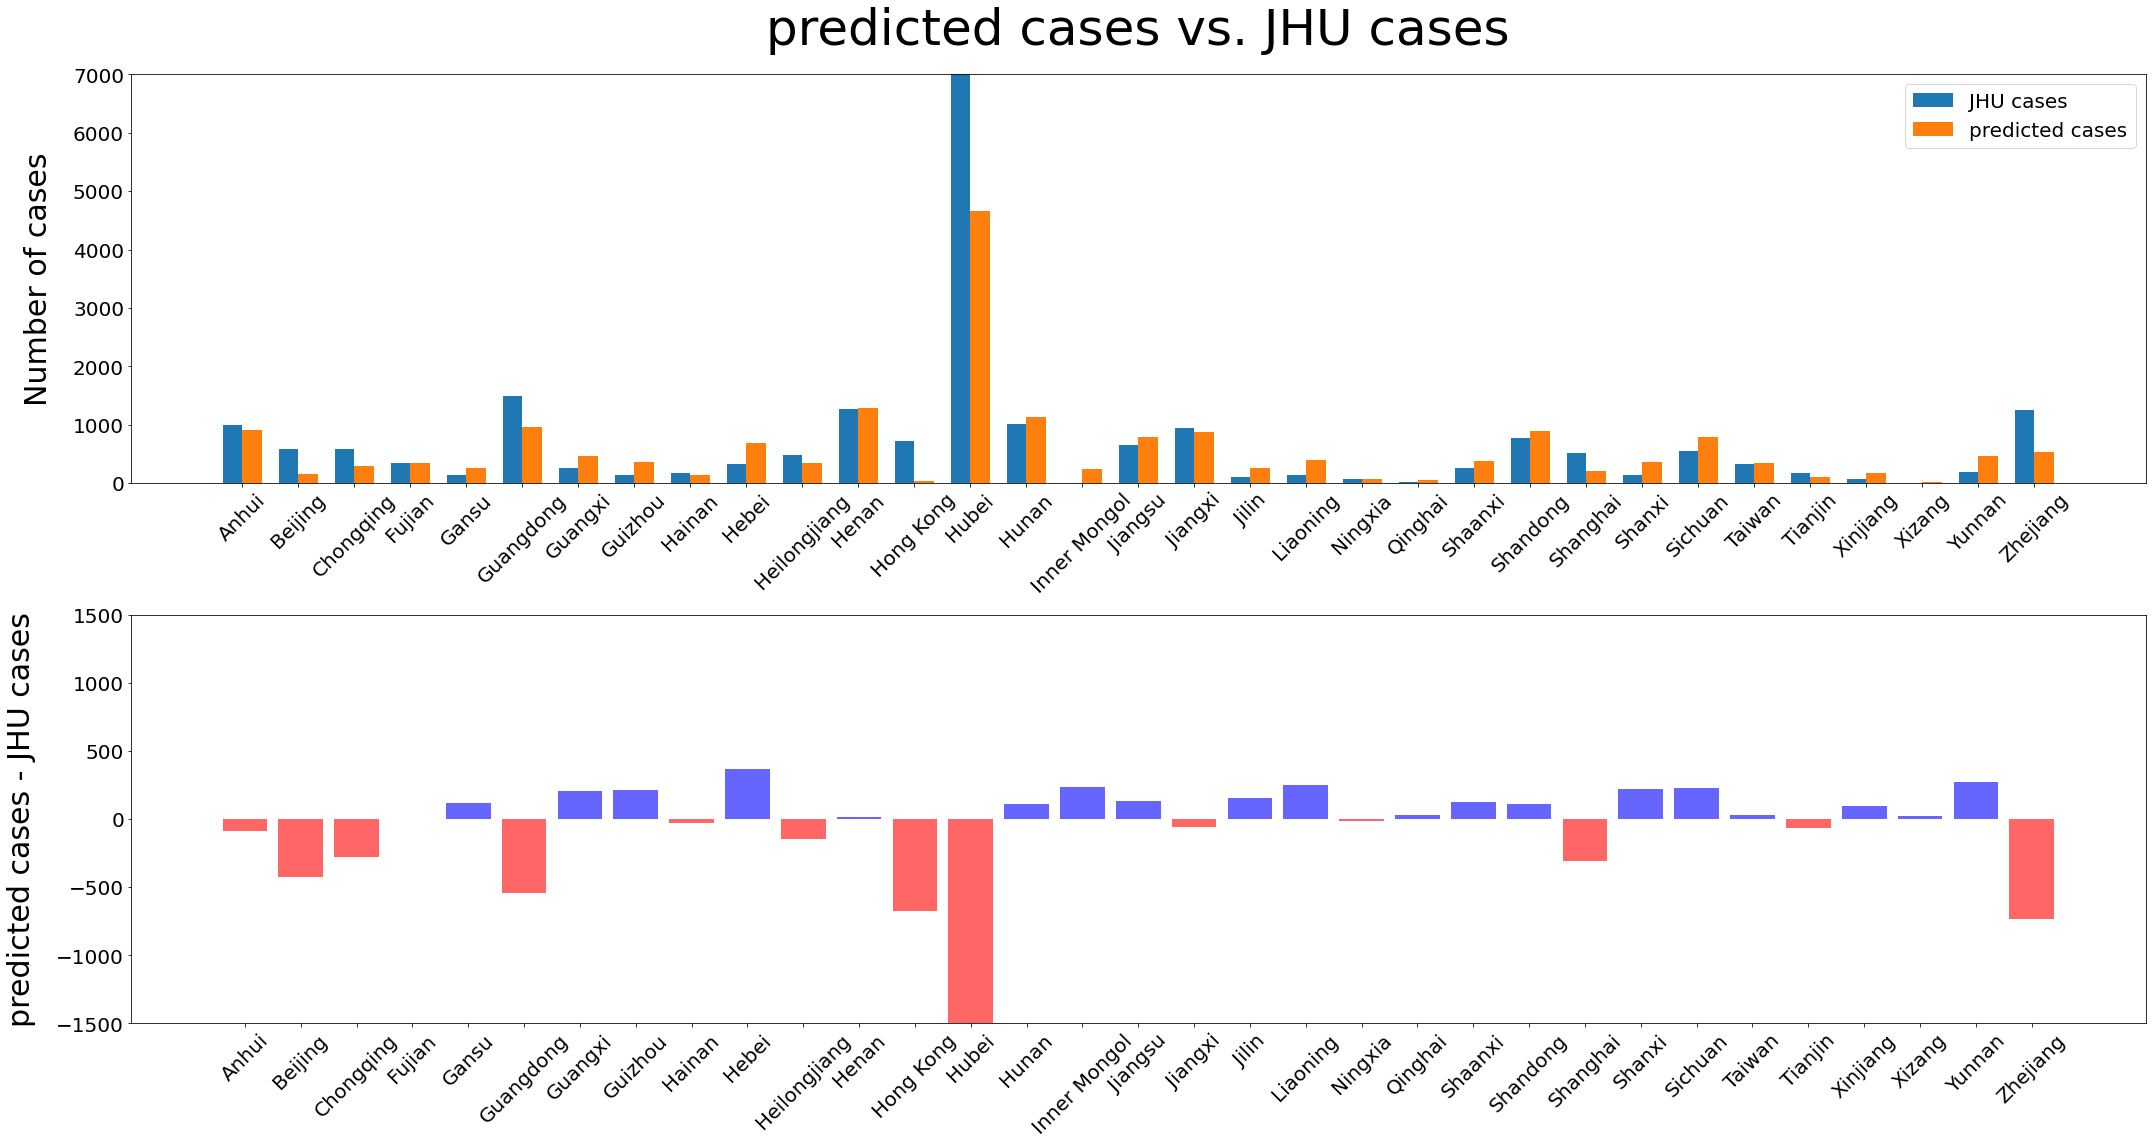

In [30]:
plot_JHU_vs_predictions_bar(predicted_with_JHU, ymin_1=0, ymax_1=7000, ymin_2=-1500, ymax_2=1500)

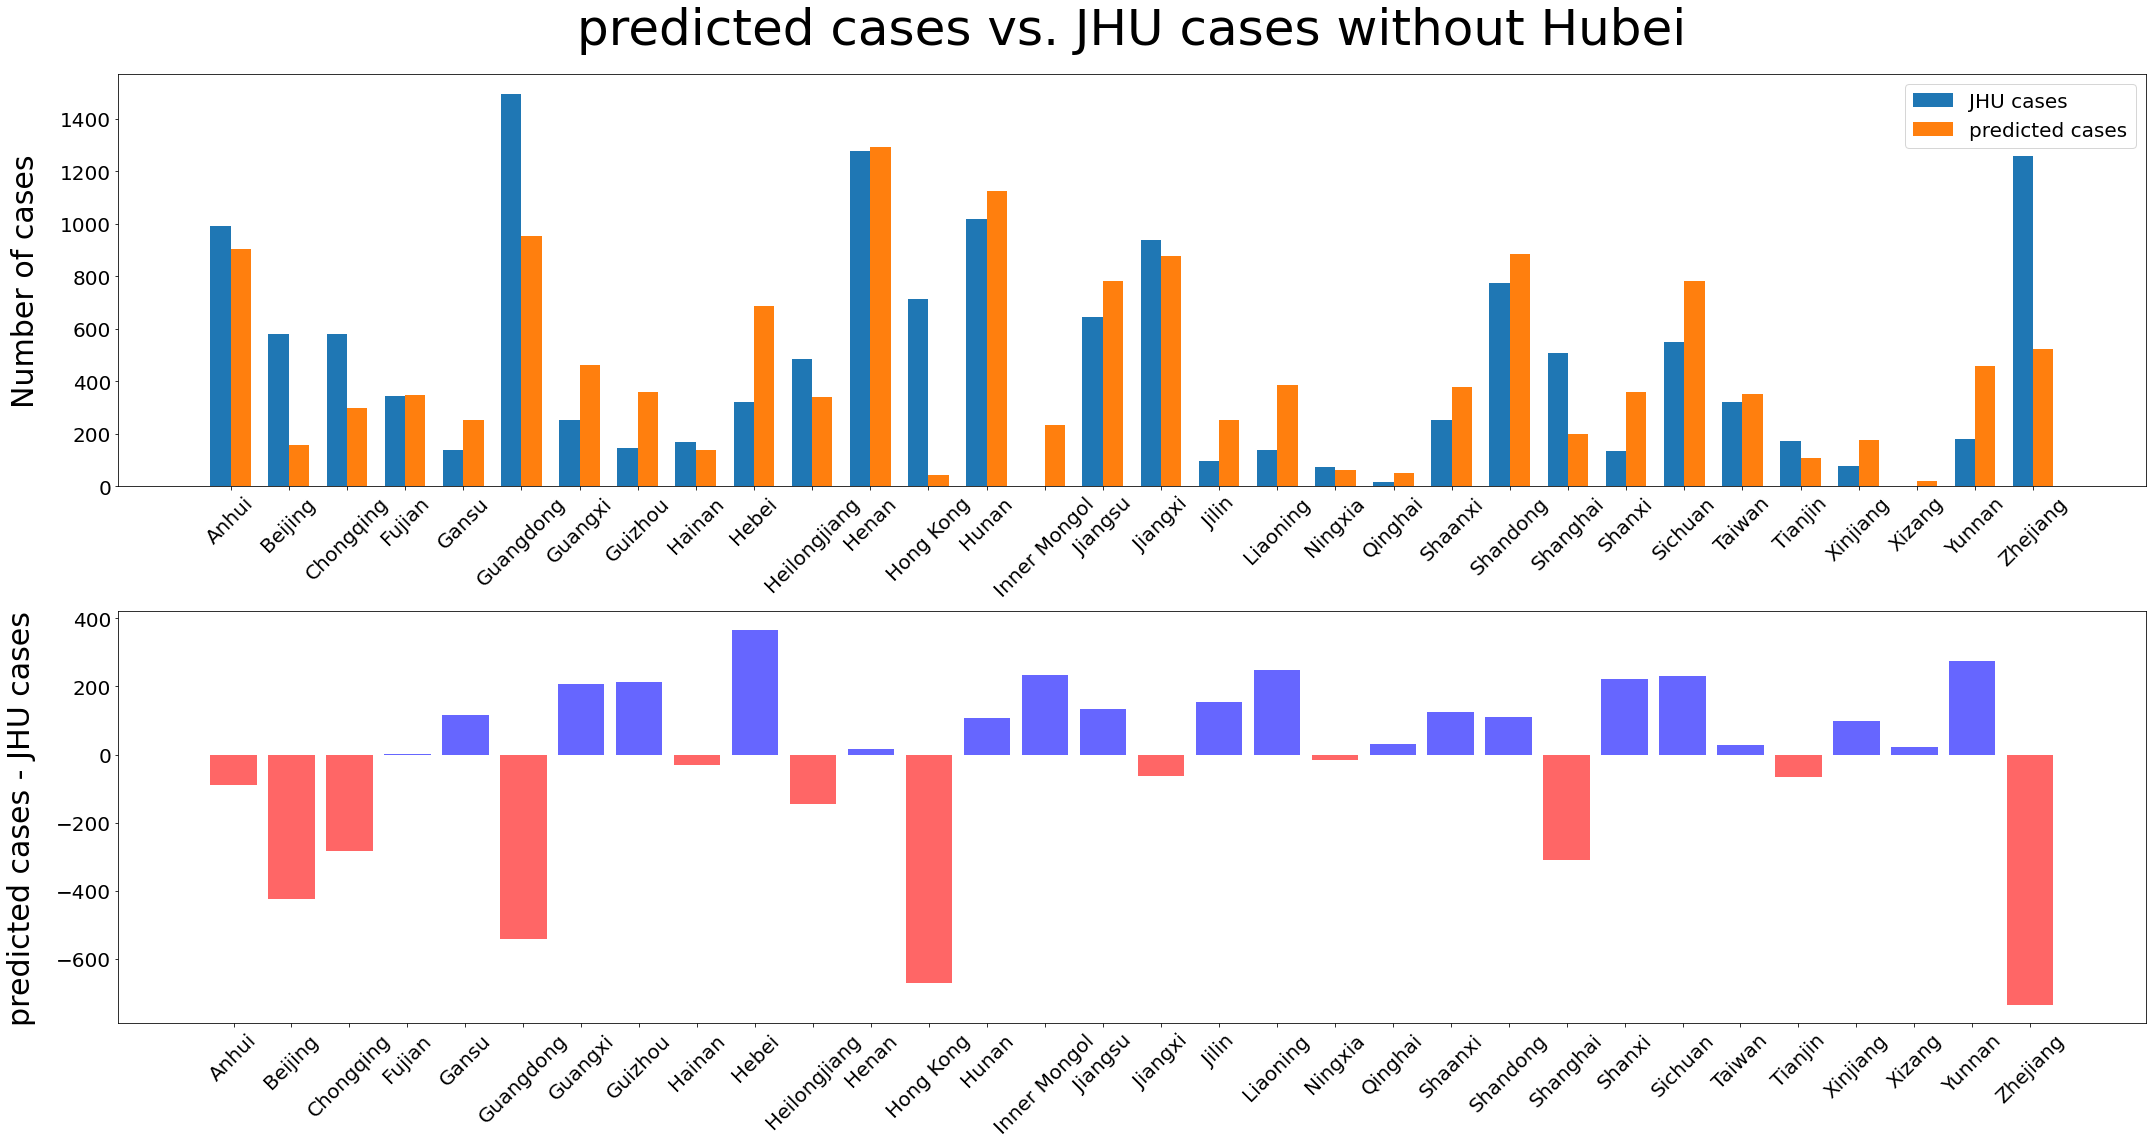

In [31]:
plot_JHU_vs_predictions_bar(predicted_with_JHU_without_hubei, title="predicted cases vs. JHU cases without Hubei")

## <center>Total cases</center>

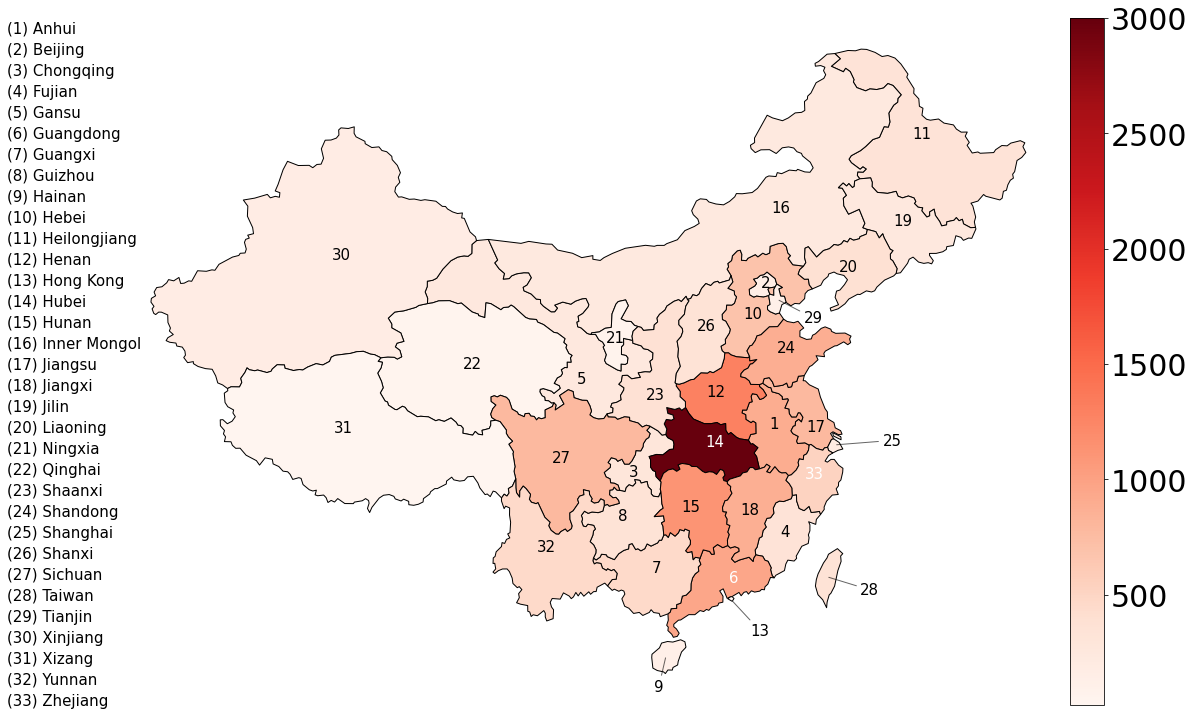

In [32]:
plot_shapefile_map(data=predicted_with_JHU, 
                   column_name="TC",
                   title="Total cases",
                   color="Reds",
                   vmax=3000,
                   save=True)

## <center>JHU cases</center>

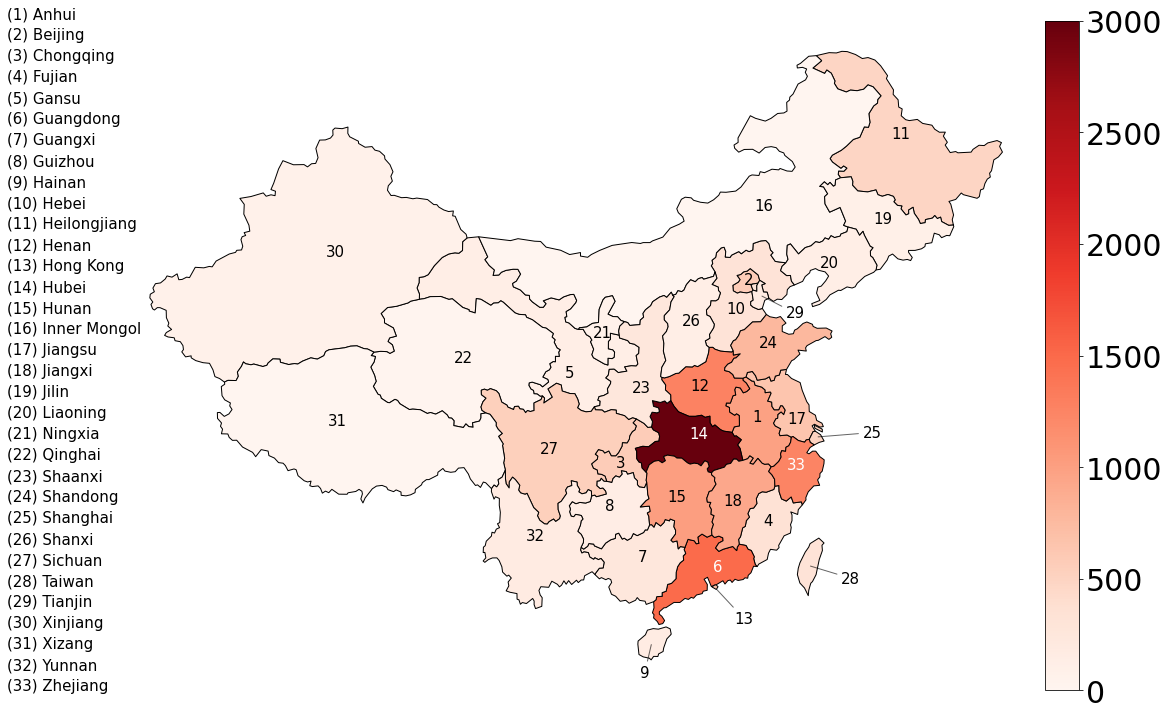

In [33]:
plot_shapefile_map(data=predicted_with_JHU, 
                   column_name="JHU_cases",
                   title="JHU cases",
                   color="Reds",
                   vmax=3000,
                   save=True)

## <center>predicted cases - JHU (log10)</center>

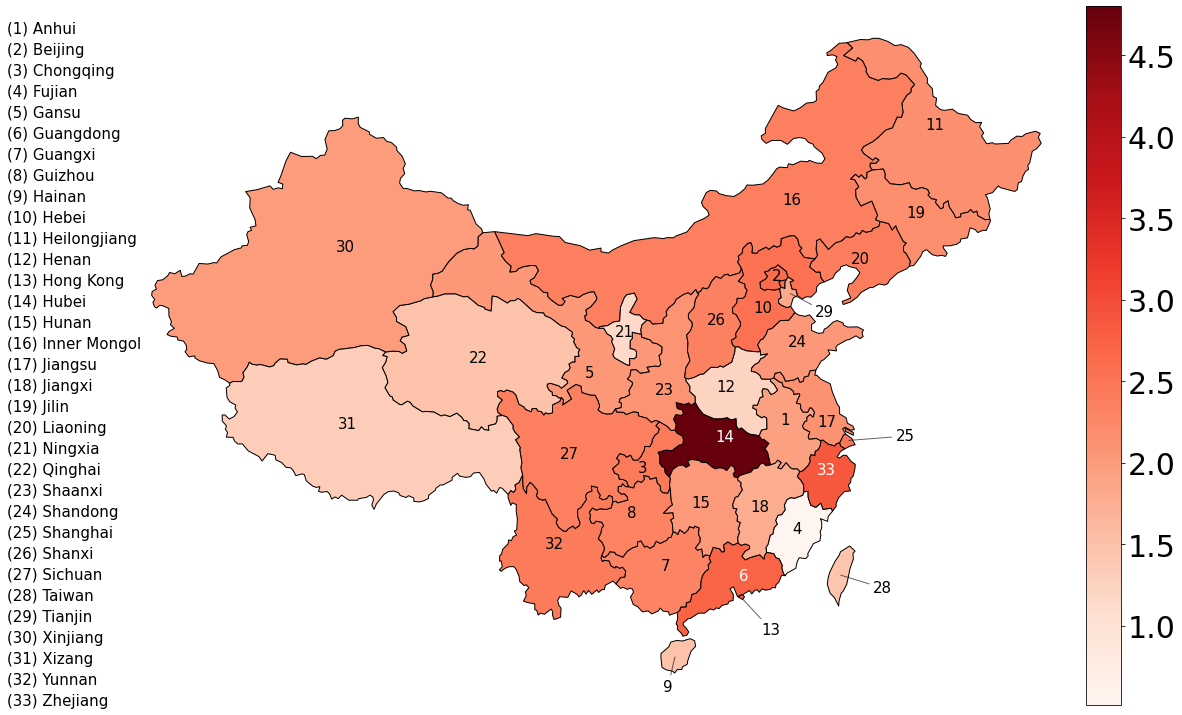

In [34]:
plot_shapefile_map(data=predicted_with_JHU,
         column_name="diff_log10",
         title="predicted cases - JHU (log10)",
         color="Reds",
         save=True)

In [35]:
print(predicted_with_JHU
      .sort_values(by="differences", ascending=False)
      .rename(columns={"uniqu_d": "province",
                       "TC": "prediction",
                       "JHU_cases": "JHU",
                       "differences": "difference",
                       "diff_log10": "difference (log10)",
                       "differences_p": "difference (%)"
                      })
      .to_latex(index=False,
                columns=["admin",
                         "province",
                         "prediction",
                         "JHU",
                         "difference",
                         "difference (log10)",
                         "difference (%)"],
                caption="Summary table of province-level aggregated predictions and JHU data from January to March. The table shows additionally absolute and percentage differences between predictions and JHU data in the columns \\textit{difference} and \\textit{difference (\%)}. Rows are sorted by the values of the column \\textit{difference}",
                label="tab:summary-predictions-vs-JHU",
                formatters=[None, None, "{:0.2f}".format, "{:0.0f}".format, "{:0.2f}".format, "{:0.2f}".format, "{:0.2f}".format]))


\begin{table}
\centering
\caption{Summary table of province-level aggregated predictions and JHU data from January to March. The table shows additionally absolute and percentage differences between predictions and JHU data in the columns \textit{difference} and \textit{difference (\%)}. Rows are sorted by the values of the column \textit{difference}}
\label{tab:summary-predictions-vs-JHU}
\begin{tabular}{llrrrrr}
\toprule
    admin &     province & prediction &   JHU & difference & difference (log10) & difference (\%) \\
\midrule
    China &        Hebei &     686.13 &   321 &     365.13 &               2.56 &          53.22 \\
    China &       Yunnan &     456.37 &   182 &     274.37 &               2.44 &          60.12 \\
    China &     Liaoning &     386.56 &   139 &     247.56 &               2.39 &          64.04 \\
    China & Inner Mongol &     234.37 &     0 &     234.37 &               2.37 &         100.00 \\
    China &      Sichuan &     780.24 &   550 &     230.24 &    

In [36]:
print(metrics_predictions_vs_JHU(predicted_with_JHU)
      .to_latex(caption="RMSE, MAE and R2 metrics of JHU data and predictions of all provinces and all provinces without hubei",
                label="tab:metrics-predictions-vs-jhu",
                formatters=["{:0.2f}".format, "{:0.2f}".format, "{:0.3f}".format]))


\begin{table}
\centering
\caption{RMSE, MAE and R2 metrics of JHU data and predictions of all provinces and all provinces without hubei}
\label{tab:metrics-predictions-vs-jhu}
\begin{tabular}{lrrr}
\toprule
{} &     RMSE &     MAE &    R2 \\
\midrule
All  provinces & 10995.69 & 2104.67 & 0.094 \\
Without Hubei  &   267.82 &  197.09 & 0.564 \\
\bottomrule
\end{tabular}
\end{table}



# Feature visualisation

## <center>Raster of the feature ACCESS</center>

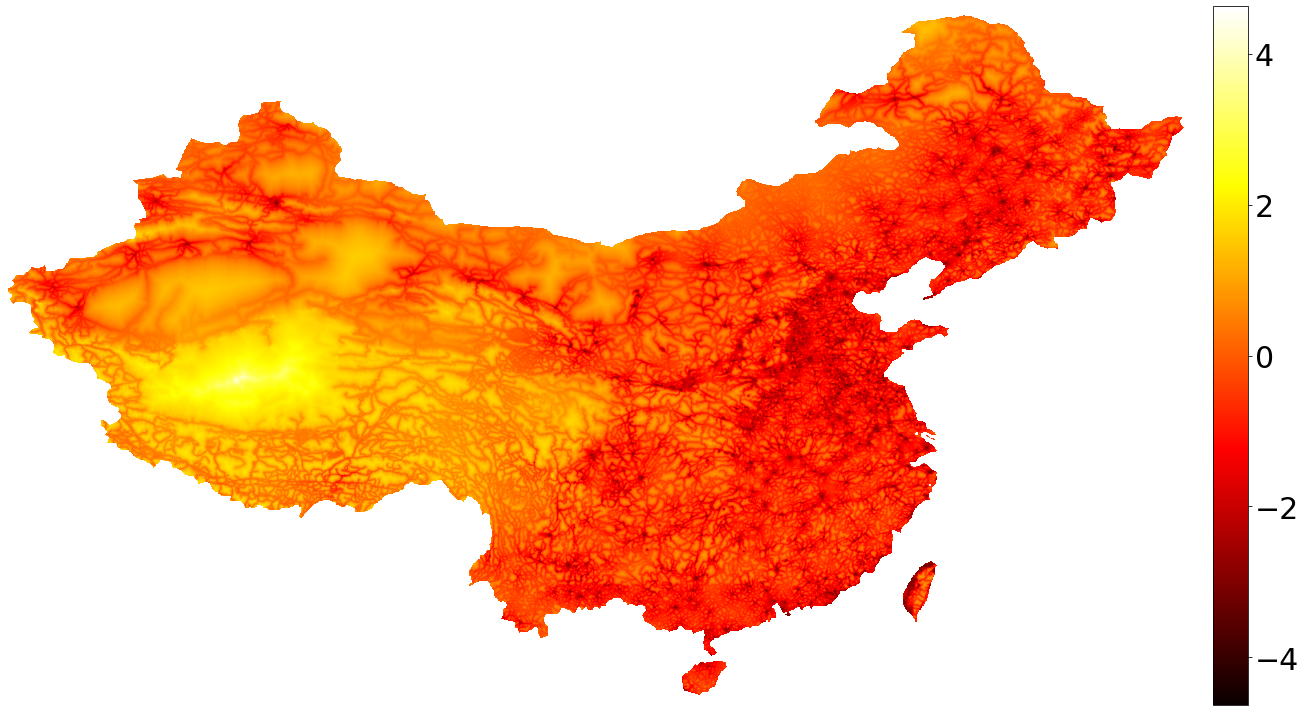

In [37]:
plot_raster_feature(flattened_feature_data=featureData["ACCESS"], name="ACCESS", save=True)

## <center>Raster of the feature PET</center>

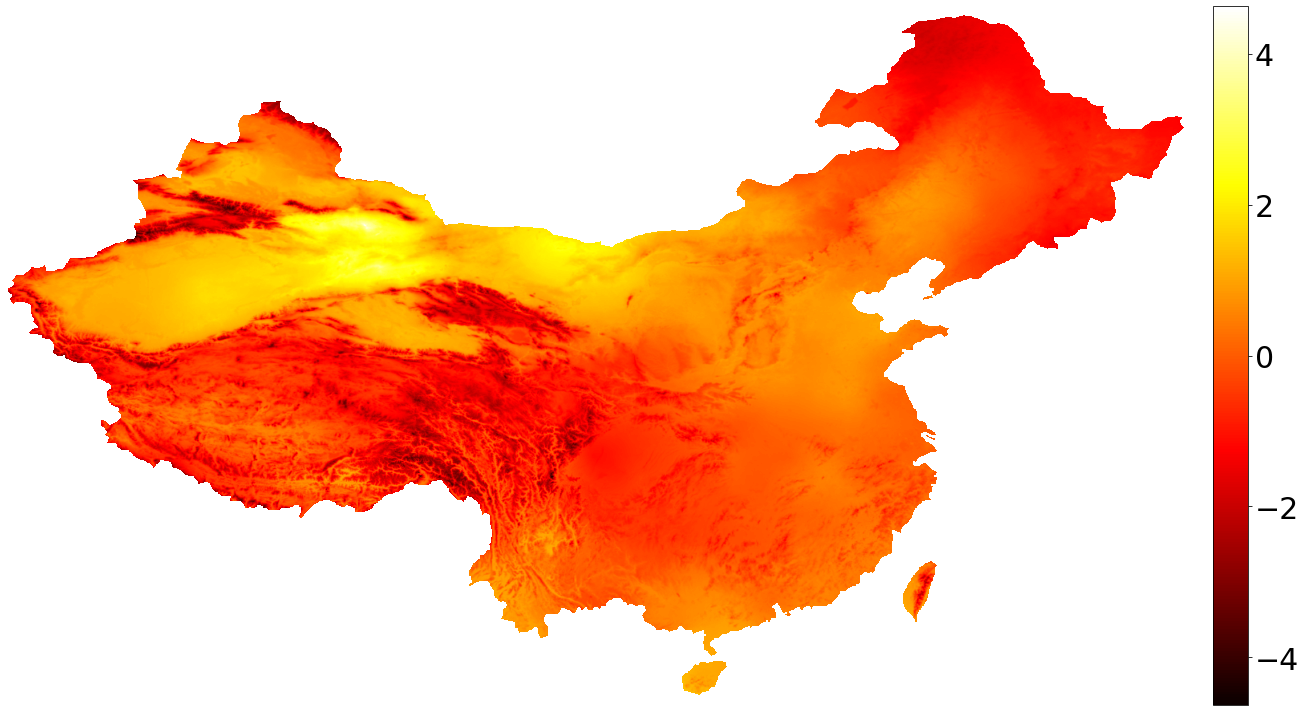

In [38]:
plot_raster_feature(flattened_feature_data=featureData["PET"], name="PET", save=True)

## <center>Raster of the feature POP</center>

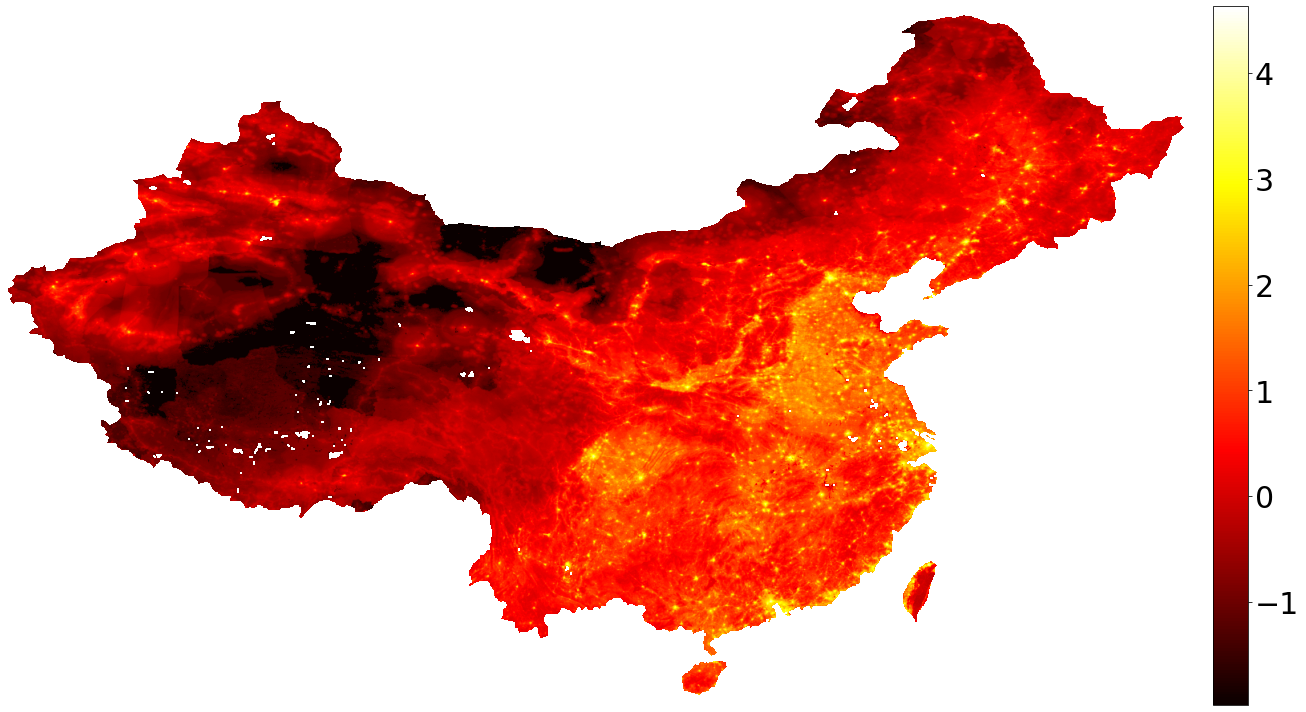

In [39]:
plot_raster_feature(flattened_feature_data=featureData["POP"], name="POP", save=True)

## <center>Raster of the feature URBAN</center>

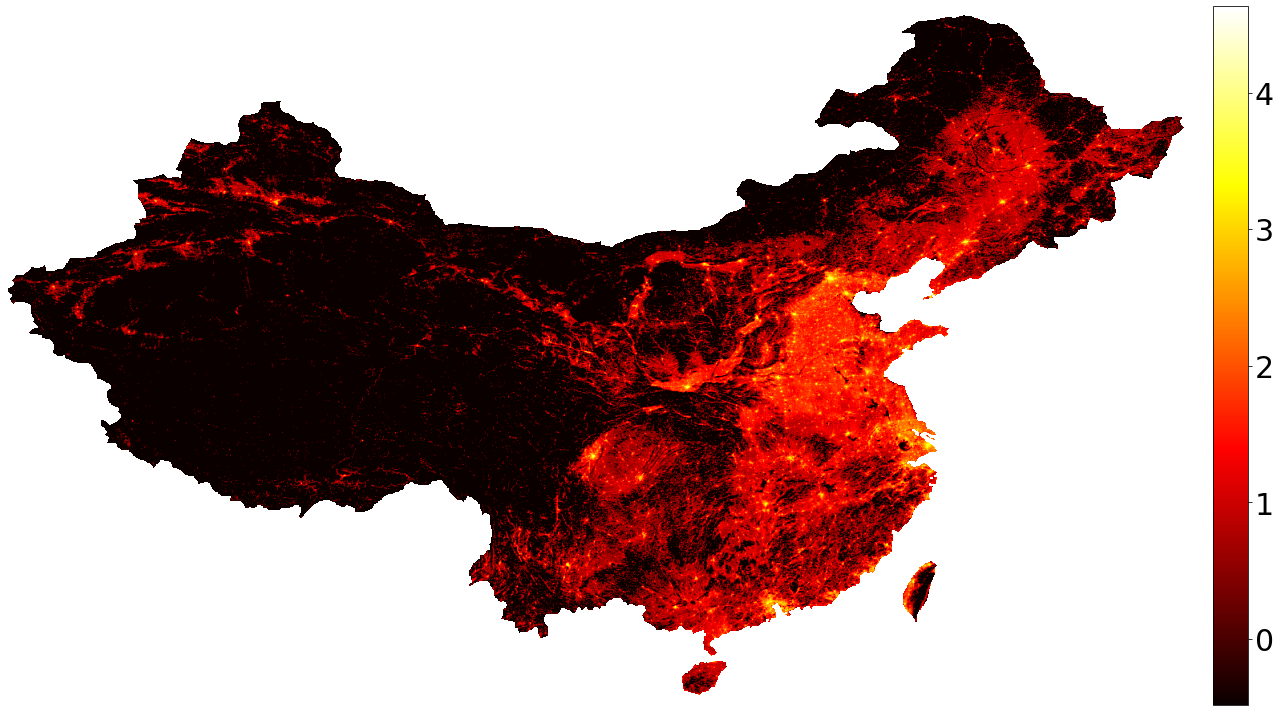

In [40]:
plot_raster_feature(flattened_feature_data=featureData["URBAN"], name="URBAN", save=True)

## <center>Raster of the feature WACCESS</center>

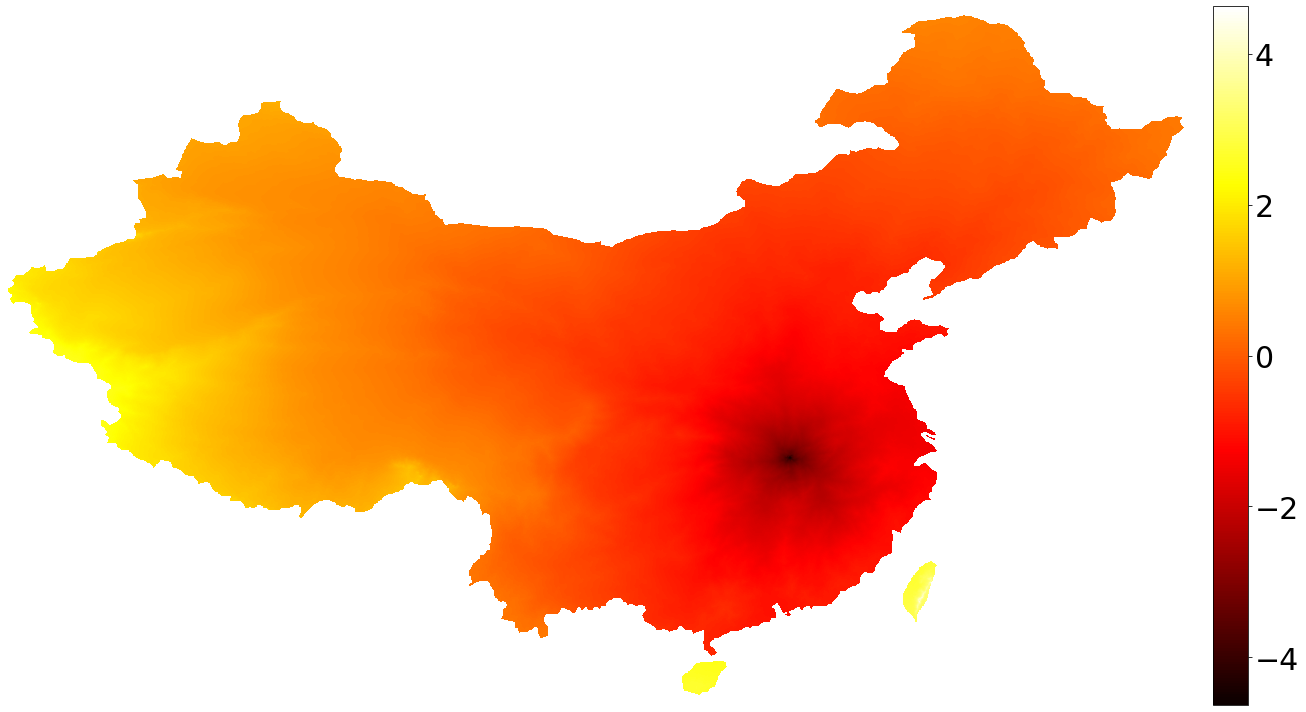

In [41]:
plot_raster_feature(flattened_feature_data=featureData["WACCESS"], name="WACCESS", save=True)